# Predição de qualidade de frutas
Esse notebook tem como objetivo a predição de qualidade de frutas (Fresco X Podre), utilizando o dataset [Fruits fresh and rotten for classification](https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification), disponível no Kaggle.

Para isso, utilizaremos redes neurais convolucionais, com o auxílio da biblioteca Tensorflow.

Esse notebook têm forte inspiração no [notebook](https://www.kaggle.com/code/akhileshdkapse/fruit-quality-classifier-for-noobs) do usuário [Akhilesh D. Kapse](https://www.kaggle.com/akhileshdkapse), também disponível no Kaggle.

## Importando Bibliotecas

In [29]:
import numpy as np 
import pandas as pd
from random import shuffle

import os

import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import pickle

import keras 
from keras.utils  import to_categorical
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

## Análise do dataset

In [30]:
# Carregando dados aleatórios
x = []
path='/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'
for sub_dir in tqdm(os.listdir(path)):
    print(sub_dir)
    main=os.path.join(path, sub_dir)
    
    i=0
    for img_name in os.listdir(main):
        if i>=6:
            break
        img=cv2.imread(os.path.join(main, img_name))
        img=cv2.resize(img,(100,100))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        x.append(img)
        i+=1

x = np.array(x)

 33%|███▎      | 2/6 [00:00<00:00, 12.35it/s]

rottenbanana
freshoranges
rottenoranges


100%|██████████| 6/6 [00:00<00:00, 13.48it/s]

freshbanana
rottenapples
freshapples


In [31]:
x.shape

(36, 100, 100, 3)

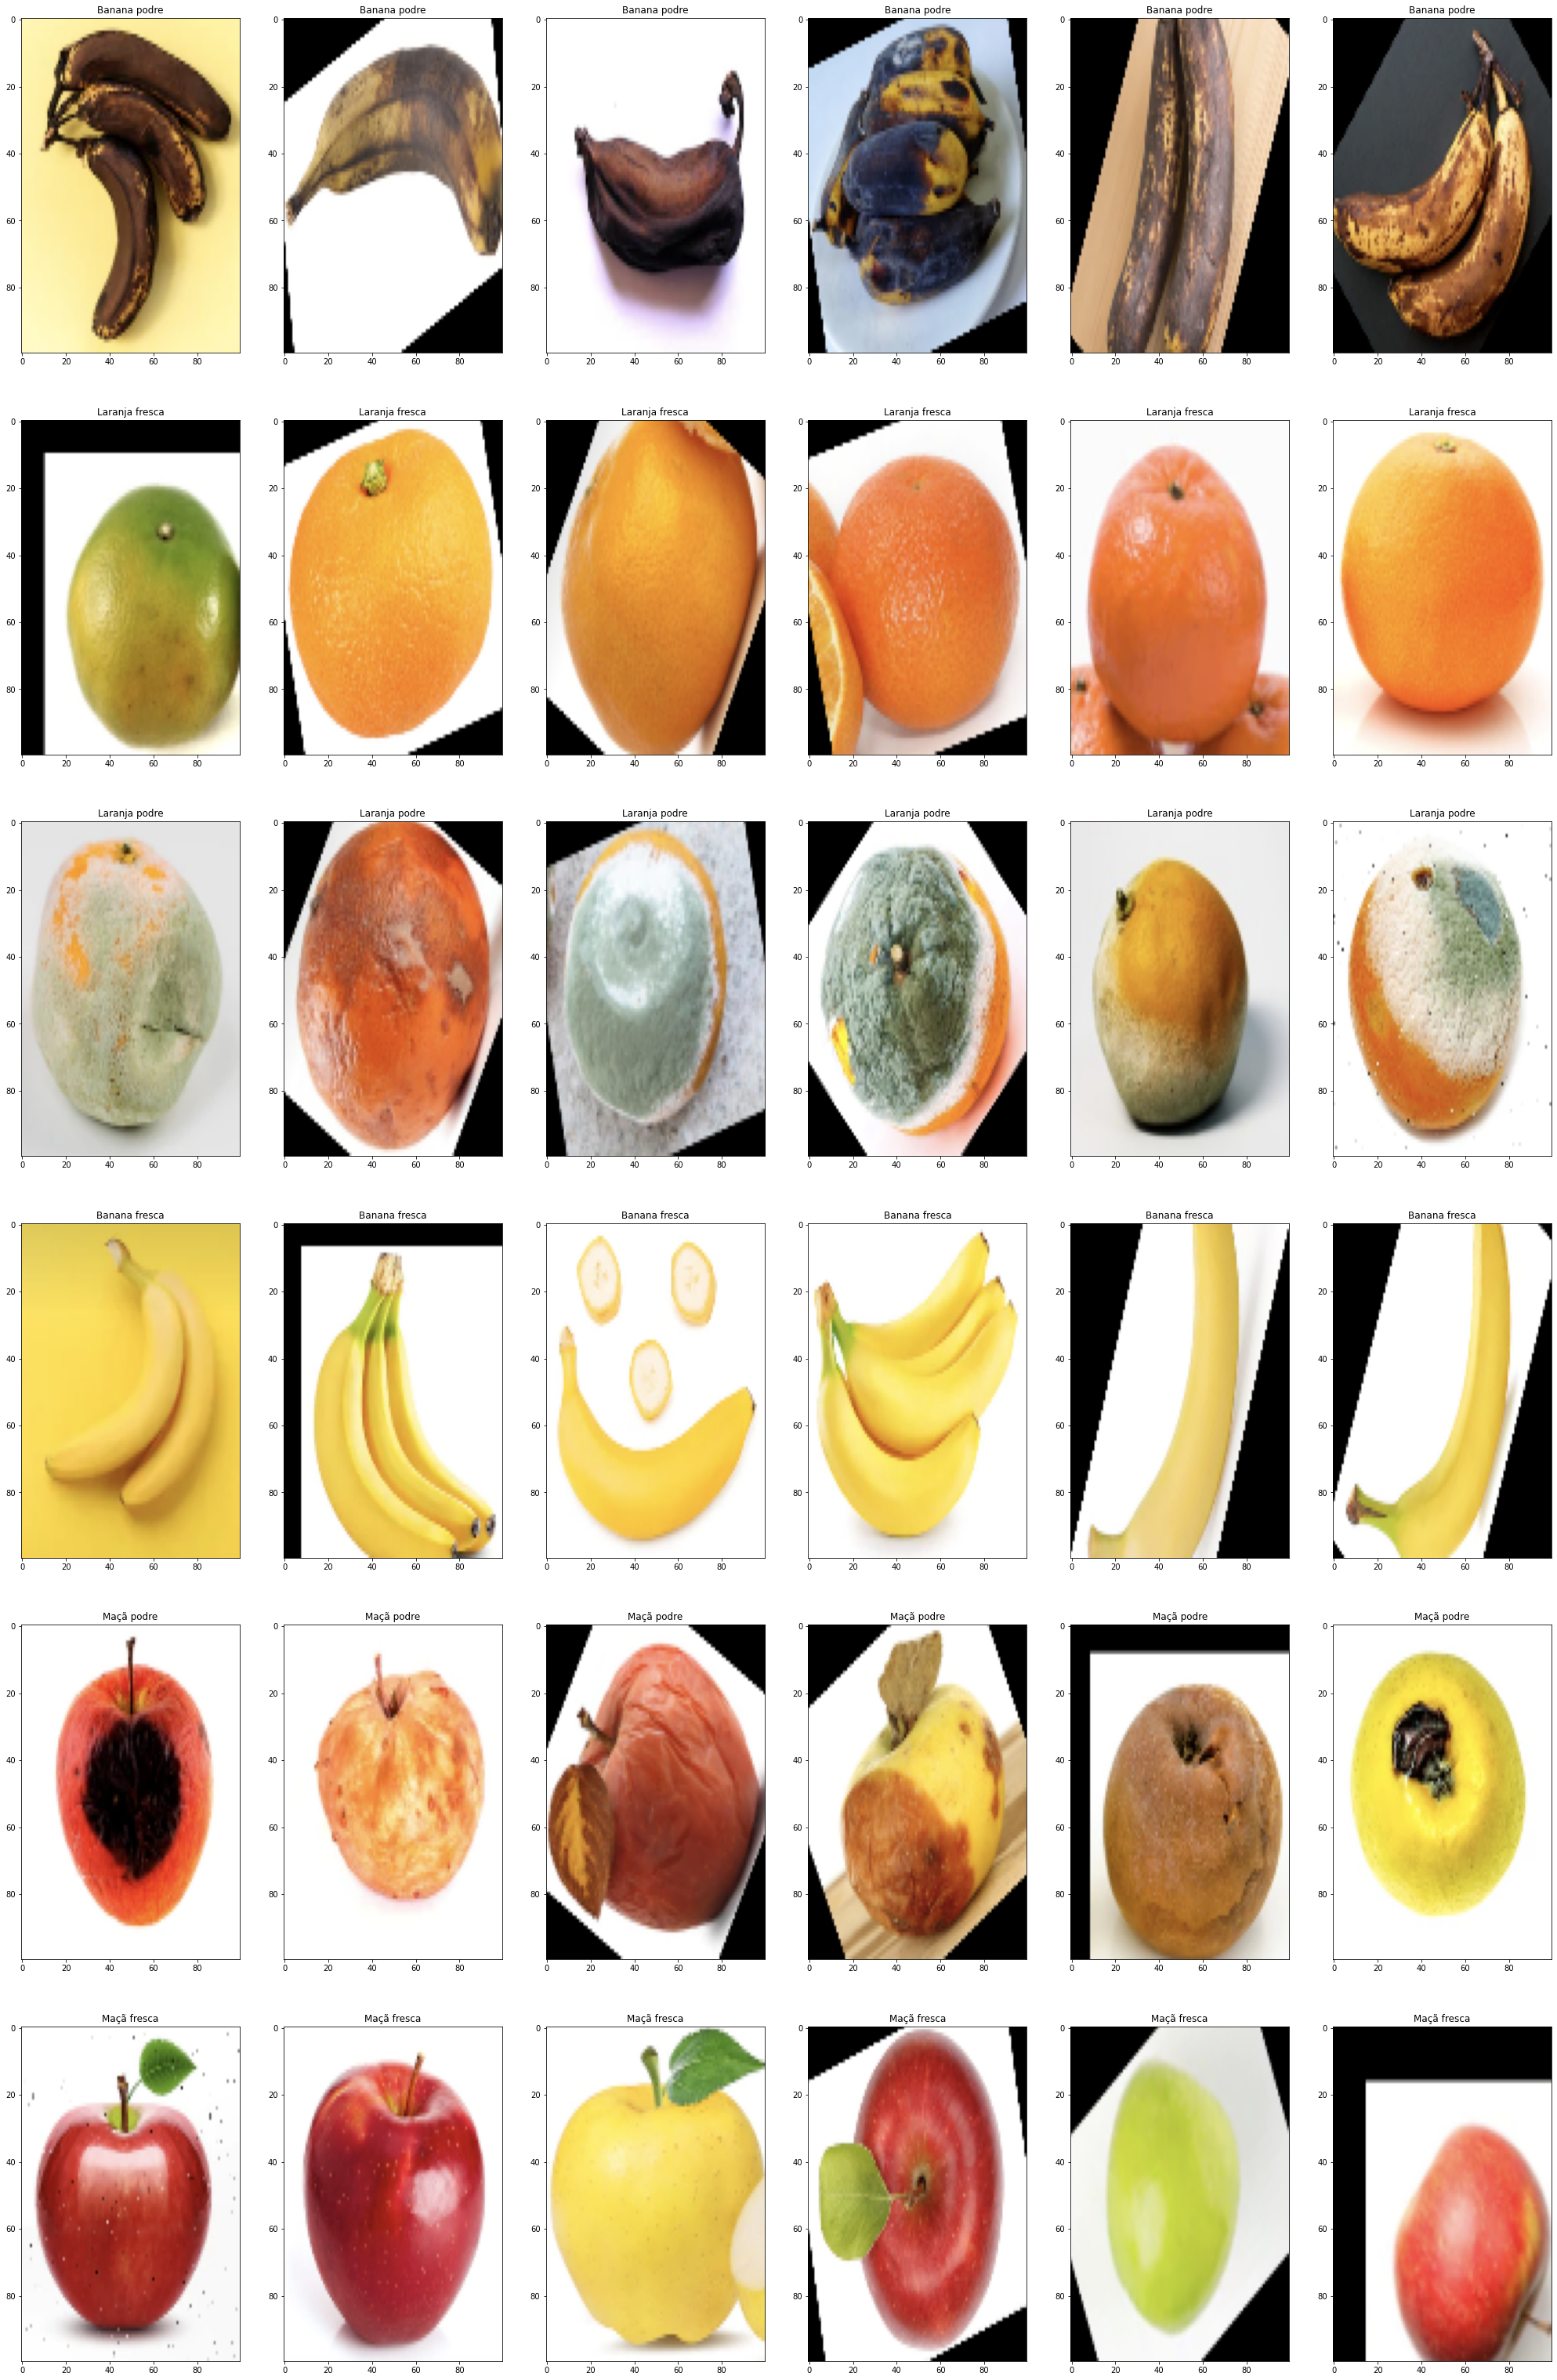

In [34]:
list_frutas = ['Banana podre', 'Laranja fresca', 'Laranja podre', 'Banana fresca', 'Maçã podre', 'Maçã fresca']

fig, ax = plt.subplots(6, 6, figsize = (35,55))

for i, img in enumerate(x):
    ax[i//6][i%6].imshow(img, aspect='auto')
    ax[i//6][i%6].set_title(list_frutas[i//6])

plt.show()

In [6]:
# Deletando conjunto de dados
del x

Analisando as imagens, é possível verificar que os as imagens não contém fundos e estão centralizadas, o que facilita o treinamento do modelo, porém envieza ele para apenas esse tipo de imagem. Isso pode ser ruim para o caso de imagens com muita poluição visual ou que não estejam centralizadas.

É bacana identificar também que algumas imagens estão rotacionadas, com a fruta cortada/aberta e com ruídos. Isso traz mais diversidade para o modelo e o torna mais robusto.

## Carregando dados de treino e teste

In [7]:
# Dados de teste
qualidade = ['fresh', 'rotten']

X_train, y_train = [], []
aux = []

for cata in tqdm(os.listdir('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train')):
    # Fresco
    if qualidade[0] in cata:
        main = os.path.join('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train', cata)
        for img_name in os.listdir(main):
            img = cv2.imread(os.path.join(main, img_name))
            img = cv2.resize(img,(100, 100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aux.append([img, 0])
    # Podre
    else:
        main = os.path.join('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train', cata)
        for img_name in os.listdir(main):
            img = cv2.imread(os.path.join(main, img_name))
            img = cv2.resize(img,(100, 100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aux.append([img, 1])

# Embaralhando os dados
shuffle(aux)

for imgs, labels in tqdm(aux):
    X_train.append(imgs)
    y_train.append(labels)

100%|██████████| 10901/10901 [00:00<00:00, 823347.04it/s]


In [8]:
y_train=np.array(y_train)
X_train=np.array(X_train)

y_ser=pd.Series(y_train)

# Verificando o balanceamento dos dados
y_ser.value_counts()

1    6161
0    4740
dtype: int64

In [9]:
# Dados de teste
qualidade = ['fresh', 'rotten']

X_val, y_val = [], []
aux = []

for cata in tqdm(os.listdir('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test')):
    # Fresco
    if qualidade[0] in cata:
        main = os.path.join('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test', cata)
        for img_name in os.listdir(main):
            img = cv2.imread(os.path.join(main, img_name))
            img = cv2.resize(img,(100, 100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aux.append([img, 0])
    # Podre
    else:
        main=os.path.join('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test', cata)
        for img_name in os.listdir(main):
            img = cv2.imread(os.path.join(main, img_name))
            img = cv2.resize(img,(100, 100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aux.append([img, 1])

# Embaralhando os dados
shuffle(aux)

for imgs, labels in tqdm(aux):
    X_val.append(imgs)
    y_val.append(labels)

100%|██████████| 2698/2698 [00:00<00:00, 815408.00it/s]


In [10]:
y_val= np.array(y_val)
X_val=np.array(X_val)

y_ser=pd.Series(y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

é possível ver uma pequena diferença na contagem de valores 1 e 0. Porém, não é uma diferença tão grande, logo não sendo um problema para o modelo.

## Criando modelo

O modelo recebe uma imagem de input de 100x100 pixels e 3 canais de cor (RGB), aplica uma série de camadas convolucionais para extrair características das imagens, seguido de uma camada de pooling para reduzir a dimensionalidade e uma camada de dropout para evitar overfitting, após a série de camadas, temos uma camada de "Flatten" para transformar a imagem em um vetor e uma camada densa para classificar a imagem, no fim uma camada densa com uma função de ativação sigmoid para retornar a probabilidade da fruta ser fresca ou podre. 


In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [13]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [14]:
# Normalizando os dados (dividindo cada pixel por 255 e os colocando na mesma escala)
X_train= X_train/255.0
X_val= X_val/255.0

### Treinando modelo

In [15]:
history = model.fit(X_train, y_train, batch_size=20, validation_data=(X_val, y_val),epochs= 50)

Epoch 1/50
546/546 [==============================] - 28s 52ms/step - loss: 0.3544 - accuracy: 0.8818 - val_loss: 2.0628 - val_accuracy: 0.7620
Epoch 2/50
546/546 [==============================] - 28s 51ms/step - loss: 0.1863 - accuracy: 0.9318 - val_loss: 0.1595 - val_accuracy: 0.9489
Epoch 3/50
546/546 [==============================] - 29s 52ms/step - loss: 0.1529 - accuracy: 0.9440 - val_loss: 0.2289 - val_accuracy: 0.9270
Epoch 4/50
546/546 [==============================] - 27s 50ms/step - loss: 0.1279 - accuracy: 0.9538 - val_loss: 0.1347 - val_accuracy: 0.9611
Epoch 5/50
546/546 [==============================] - 28s 51ms/step - loss: 0.1111 - accuracy: 0.9588 - val_loss: 0.0797 - val_accuracy: 0.9696
Epoch 6/50
546/546 [==============================] - 28s 51ms/step - loss: 0.0980 - accuracy: 0.9655 - val_loss: 0.7687 - val_accuracy: 0.9096
Epoch 7/50
546/546 [==============================] - 28s 51ms/step - loss: 0.0967 - accuracy: 0.9658 - val_loss: 0.1179 - val_accuracy:

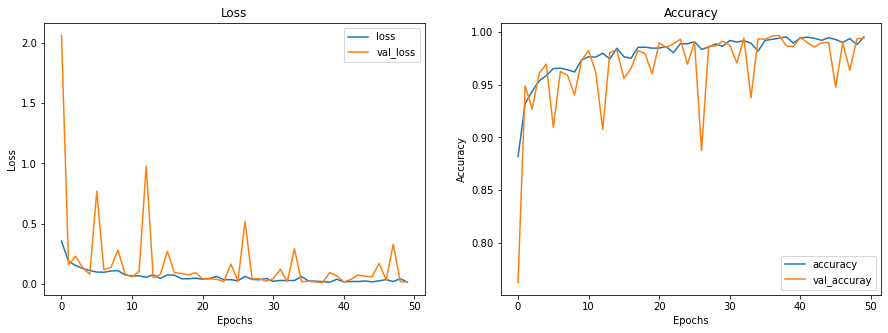

In [17]:
# Plotando loss e accuracy
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')

ax.legend()

ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuray')

ax2.legend()

plt.show()

In [18]:
model.evaluate(X_val, y_val)

85/85 [==============================] - 1s 8ms/step - loss: 0.0162 - accuracy: 0.9944


[0.016230028122663498, 0.9944403171539307]

### Testando o modelo

In [19]:
def predict(img, model):
    img = img.reshape(1,100,100,3)
    model_out = model.predict([img])
    
    if model_out[0][0] != 1:
        return 'Fresco'
    else:
        return 'Podre'

Text(0.5, 0, 'Predição: Podre')

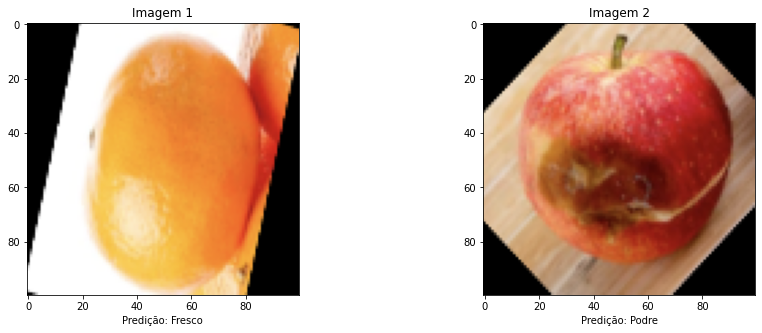

In [20]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pred = predict(X_val[3], model)

ax.set_title('Imagem 1')
ax.imshow(X_val[3])
ax.set_xlabel('Predição: {}'.format(pred))

pred = predict(X_val[5], model)
ax2.set_title('Imagem 2')
ax2.imshow(X_val[5])
ax2.set_xlabel('Predição: {}'.format(pred))


In [21]:
preds = model.predict_classes(X_val[-36*11:-36*10])

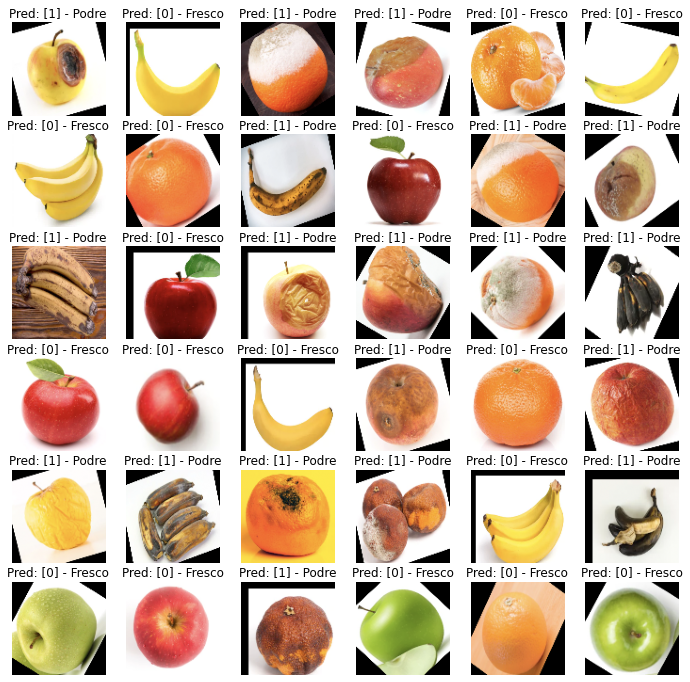

In [26]:
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
for img, ax, pred in zip(X_val[-36*11:-36*10], ax.ravel(), preds):
    ax.imshow(img)
    if pred != 1:    
        ax.set_title(f'Pred: {pred} - Fresco')
    else:
        ax.set_title(f'Pred: {pred} - Podre')
    ax.axis('off')

plt.show()

### Salvando o modelo

In [27]:
model.save('./models/rottenvsfresh.h5')

## Considerações finais
O modelo se mostrou muito efetivo, afinal teve uma acurácia de quase 100%. Porém, é importante ressaltar três pontos importantes:
- o dataset é pequeno, possibilitando o enviezamento do modelo e não sendo possível afirmar que ele é robusto;
- as imagens do dataset são bastantes simples, não trazendo variedade de backgrounds e situações para as imagens, fazendo com que o modelo fique limitado a certas situações;
- as imagens de treino e teste são bem parecidas, o que, provavelmente trouxe essa acurácia tão grande.

Trazer maior variedade de imagens, com backgrounds e situações diferentes, e imagens mais complexas em maior quantidade seria um primeiro passo para fazer um modelo melhor, além de adicionar maior variação para os dados de treino e teste, pois assim podemos verificar se o modelo aprendeu de fato a classificar as imagens.